In [172]:
import os
import sys
import gseapy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
import yaml
import numpy as np
import pandas as pd
import scanpy as sc
import random
import matplotlib.pyplot as plt

In [173]:
notebook_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(notebook_dir)
from AE.AE import Autoencoder
from AE.AEclassifier import AEClassifier, ClassificationDataset

In [174]:
## Load parameters
# Autoencoder params:
with open('../test_params.yaml', "r") as f:
    best_params=yaml.safe_load(f)
# Classifier params
with open('../classifier_params.yaml', "r") as f:
    classifier_params=yaml.safe_load(f)

# load lables
with open('../Data/training_classifier_data.pkl','rb') as f:
    data=pickle.load(f)
    labels=data['labels_names']
    num_classes=data['num_classes']
    del data
    
# load gene names
with open('../Data/training_data.pkl', 'rb') as f:
    data=pickle.load(f)
    genes=data['genes']
    full_data=data['full_dataset']
    del data

with open('../models/standard_scaler.pkl','rb') as f:
    ss=pickle.load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [175]:
# recreate model

# Extract hidden dimensions based on the suggested params
best_hidden_dims = []
n_hidden_layers = best_params['n_hidden_layers']
for i in range(n_hidden_layers):
    # Append the hidden dimension for each layer
    if f'h_dim_{i}' in best_params:
        best_hidden_dims.append(best_params[f'h_dim_{i}'])


best_latent_dim = best_params['latent_dim']
best_dropout_rate=best_params['dropout_rate']
input_dim=len(genes)
# Extract hidden dimensions based on the suggested params
classifier_hidden_dims = []
n_hidden_layers = classifier_params['n_hidden_layers']
for i in range(n_hidden_layers):
    # Append the hidden dimension for each layer
    if f'h_dim_{i}' in classifier_params:
        classifier_hidden_dims.append(classifier_params[f'h_dim_{i}'])
classifier_dropout_rate=classifier_params['dropout_rate']

In [176]:
AE_arch = Autoencoder(input_dim,
                      best_latent_dim,
                      best_hidden_dims,
                     best_dropout_rate)


classifier_model = AEClassifier(AE_arch.encoder,num_classes=num_classes, 
                                        latent_dim=best_latent_dim,
                                        hidden_dims=classifier_hidden_dims, 
                                        dropout_rate=classifier_dropout_rate).to(device)
classifier_model.load_state_dict(torch.load('../models/classifier_model.pth', map_location=device))
classifier_model = nn.Sequential(
    classifier_model,
    nn.Softmax(dim=1)  # apply softmax across classes
)

classifier_model.eval()
classifier_model.to(device)

Sequential(
  (0): AEClassifier(
    (encoder): Sequential(
      (0): HiddenBlock(
        (block): Sequential(
          (0): Linear(in_features=10000, out_features=1024, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.2, inplace=False)
        )
      )
      (1): HiddenBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=512, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.2, inplace=False)
        )
      )
      (2): Linear(in_features=512, out_features=128, bias=True)
    )
    (classification_head): Sequential(
      (0): ClassifierHead(
        (block): Sequential(
          (0): Linear(in_features=128, out_features=64, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.2, inplace=False)
        )
      )
      (1): Linear(in_features=64, out_features=6, bias=True)
    )
  )
  (1): Softmax(dim=1)
)

In [177]:
import shap
import shap.maskers as maskers 

In [246]:
def full_model_predict_proba(samples_features):
    # Ensure input is 2D (n_samples, n_features) even if only one sample
    if samples_features.ndim == 1:
        samples_features = samples_features.reshape(1, -1)


    # Convert numpy arrays to tensors and move to device
    # samples_tensor = torch.FloatTensor(samples_features).to(device)

    classifier_model.eval() # Ensure eval mode

    # Perform forward pass through the *full* loaded_classifier_model
    with torch.no_grad(): # No gradients needed for inference
        probabilities = classifier_model(samples_features)
        # probabilities = torch.softmax(logits, dim=1) # Get probabilities

    # Move probabilities back to CPU and convert to NumPy
    return probabilities

def get_random_sample(genes,ss):
    adata=sc.read('../Data/dataset_annotated.h5ad')
    samples=adata.obs_names
    sample_name = random.choice(samples)
    sample_gt=sc.get.obs_df(adata, keys='classification').loc[sample_name].values[0]
    sample = sc.get.var_df(adata, keys=sample_name)
    sample = sample[sample.index.isin(genes)].reindex(genes).T
    sample = ss.transform(sample)
    sample = torch.Tensor(sample).to(device)
    return sample, sample_gt, sample_name

In [247]:
sample, sample_gt, sample_name = get_random_sample(genes,ss)

In [249]:
sample, sample_gt, sample_name = get_random_sample(genes,ss)
probabilities = full_model_predict_proba(sample)
cluster_id=np.argmax(probabilities.cpu().numpy()[0])
cluster_name=labels[cluster_id]
# print(full_model_predict_proba(sample))
print(f"Predicted: {cluster_name}\nReal: {sample_gt}")

Predicted: LumA-G2
Real: LumA-G2


In [250]:
# background_subset_size =1000# Adjust size based on computation resources vs accuracy
# background_subset_indices = np.random.choice(full_data.index, background_subset_size, replace=False)
# background_data=full_data[full_data.index.isin(background_subset_indices)]
background_data=full_data
# samples_features=ss.transform(full_data[genes])

# background_features=ss.transform(background_data[genes])
background_features=torch.Tensor(background_data.to_numpy()).to(device)


In [251]:

# explainer = shap.Explainer(full_model_predict_proba, background_features, feature_names=genes)
explainer = shap.DeepExplainer(classifier_model,
                               data=background_features)

In [252]:
sample

tensor([[ 0.9829,  4.5625,  0.6886,  ..., -0.0550, -0.2974,  0.5388]])

In [253]:
shap_values = explainer.shap_values(sample)#, max_evals=20001, batch_size=1)


In [254]:
shap_values[0,:,cluster_id]

array([-6.27534289e-04,  1.45636396e-02, -2.40429793e-03, ...,
       -4.11282247e-03,  1.71893062e-05, -1.44888309e-03])

In [255]:
print(f"SHAP values shape: {shap_values.shape}")

SHAP values shape: (1, 10000, 6)


In [256]:
target_class_id=labels.index(cluster_name)

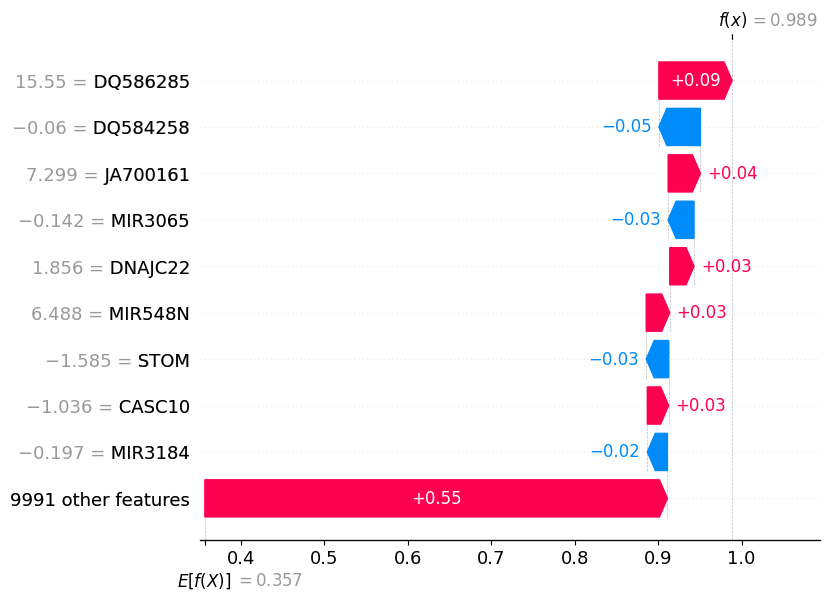

In [257]:
# Get class 2 SHAP values for sample 0
vals = shap_values[0,:,cluster_id]
base = explainer.expected_value[cluster_id]  # scalar

# Build the Explanation object
explanation = shap.Explanation(
    values=vals,
    base_values=base,
    data=sample.cpu().numpy()[0],  # the input features
    feature_names=genes  # optional
)

# Plot
shap.plots.waterfall(explanation)


In [268]:
from gseapy import Msigdb
from gseapy import GSEA
from gseapy import dotplot
import gseapy as gp

In [269]:
msig = Msigdb()
gmt = msig.get_gmt(category='h.all', dbver="2025.1.Hs")


def pathways(expr,ax):
    pre_res = gp.prerank(
        rnk=expr,  # DataFrame or path to .rnk file
        gene_sets=gmt, 
        permutation_num=10000,  # recommended ≥1000
        seed=42,
        threads=4,  # parallelization
        outdir=None
    )

    ax = dotplot(pre_res.res2d,
             column="FDR q-val",
             cmap=plt.cm.viridis,
             size=5, # adjust dot size
             show_ring=False,ax=ax, figsize=(10,15))
    return ax, pre_res.res2d


In [270]:
shaps = pd.DataFrame({'gene_name':genes, 'score':vals}).sort_values('score',ascending=False)

2025-07-07 19:25:45,245 [WARNING] Duplicated values found in preranked stats: 22.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


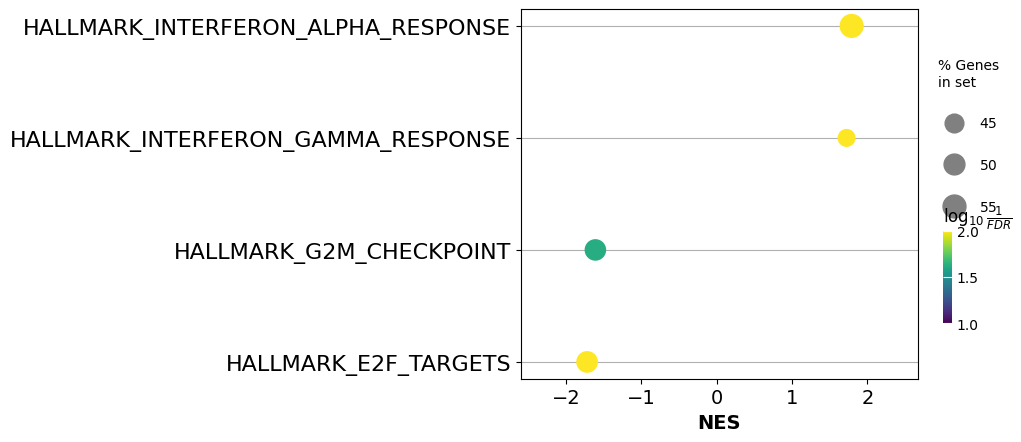

In [271]:
fig,ax=plt.subplots(1,1)
ax, res = pathways(shaps,ax)
plt.show()

In [273]:
sc.read('../Data/dataset_annotated.h5ad').obs.loc[sample_name]

scan-b external id        Q003668.C003708.S005570.l.r.m.c.lib.g.k.a.t
instrument model                                           HiSeq 2000
age at diagnosis                                                   77
tumor size                                                         23
lymph node group                                                 1to3
lymph node status                                        NodePositive
er status                                                           1
pgr status                                                          1
her2 status                                                         0
ki67 status                                                         1
nhg                                                                G2
er prediction mgc                                                   1
pgr prediction mgc                                                  1
her2 prediction mgc                                                 0
ki67 prediction mgc 

In [120]:
def get_random_sample(genes,ss):
    adata=sc.read('../Data/dataset_annotated.h5ad')
    samples=adata.obs_names
    sample_name = random.choice(samples)
    sample_gt=sc.get.obs_df(adata, keys='classification').loc[sample_name].values[0]
    sample = sc.get.var_df(adata, keys=sample_name)
    sample = sample[sample.index.isin(genes)].reindex(genes).T
    sample = ss.transform(sample)
    sample=torch.FloatTensor(sample).to(device)
    return sample, sample_gt
    

In [128]:
sample, sample_gt = get_random_sample(genes,ss)

In [130]:
# The model expects batch input, so the single sample is treated as a batch of size 1
with torch.no_grad():
    # Forward pass through the classifier model
    logits = classifier_model(sample) # Shape (1, num_classes)
    probabilities = torch.softmax(logits, dim=1) # Get probabilities, Shape (1, num_classes)
    predicted_id = torch.argmax(logits, dim=1) # Get predicted class index, Shape (1,)

In [131]:
probabilities

tensor([[2.6257e-04, 1.4421e-03, 2.4231e-03, 2.9056e-03, 9.9036e-01, 2.6057e-03]])

In [132]:
predicted_id

tensor([4])

In [133]:
labels[predicted_id]

'LumB-G3'

In [134]:
sample_gt

'LumB-G3'

In [135]:
import shap
import shap.maskers as maskers 

In [ ]:
# Use the full_model_predict_proba function and the combined background data
explainer = shap.Explainer(full_model_predict_proba, X_combined_background_np, feature_names=feature_names)

In [33]:
explainer = shap.Explainer(classifier_head_predict_proba_single_sample, combined_features_background_np, feature_names=feature_names) # Use feature_names here

['5S_rRNA',
 '7SK',
 'A1BG',
 'A2M',
 'A2ML1',
 'A4GALT',
 'AACS',
 'AADAT',
 'AAMDC',
 'AARD',
 'AATF',
 'AB056456',
 'AB074160',
 'AB075489',
 'AB167325',
 'AB167336',
 'AB209638',
 'AB231721',
 'AB231761',
 'AB240007',
 'AB240039',
 'AB305673',
 'AB305679',
 'AB305752',
 'AB305761',
 'AB305913',
 'AB306028',
 'AB306139',
 'AB360830',
 'AB360851',
 'AB749876',
 'AB749906',
 'AB776850',
 'ABAT',
 'ABCA12',
 'ABCA2',
 'ABCA3',
 'ABCA8',
 'ABCB9',
 'ABCC1',
 'ABCC11',
 'ABCC13',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC8',
 'ABCD1',
 'ABCD3',
 'ABCG1',
 'ABHD11',
 'ABHD12',
 'ABHD12B',
 'ABHD15',
 'ABHD16B',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI3BP',
 'ABLIM1',
 'ABLIM3',
 'ABO',
 'ABRACL',
 'ABTB2',
 'AC019117.1',
 'AC093627.10',
 'ACACA',
 'ACACB',
 'ACAD8',
 'ACADL',
 'ACADM',
 'ACADS',
 'ACADSB',
 'ACAN',
 'ACAP1',
 'ACAT2',
 'ACE',
 'ACE2',
 'ACER3',
 'ACHE',
 'ACKR2',
 'ACKR3',
 'ACLY',
 'ACOT4',
 'ACOT7',
 'ACOT9',
 'ACOX2',
 'ACP5',
 'ACP6',
 'ACPP',
 'ACSF2',
 'ACSL1',
 'ACSL3',
 'A